 # Modelling tests neural network



### Table of Contents

* [modèles](#modele)
* [fonction d'entrainement et de test](#train)
* [base de données à 13000 signaux par classe](#svm_features_sur_res)
* [Experiments](#exp)


je teste ici des modèles de CNN
globalement il faut beacoup de données

In [6]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim

## modèles

In [7]:

def cnn_type_1(n,n_neural, activation=nn.ReLU,input_shape=187,device='cpu'):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=n, kernel_size=7, stride=1, padding=0), # shape: (batch_size, n, 181)
        activation(),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 90)
        nn.Conv1d(in_channels=n, out_channels=n, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 86)
        activation(),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 43)
        nn.Conv1d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 41)
        activation(),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 20)
        nn.Conv1d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 18)
        activation(),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 9),
        nn.Flatten() , # shape: (batch_size, 9*n)
        nn.Linear(9*n, n_neural),
        activation(),
        nn.Linear(n_neural, 5),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model

def cnn_type_2(n,n_neural, activation=nn.ReLU,device='cpu'):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=n, kernel_size=11, stride=1, padding=0), # shape: (batch_size, n, 177)
        activation(),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 88)
        nn.Conv1d(in_channels=n, out_channels=n, kernel_size=7, stride=1, padding=0), # shape: (batch_size, n, 82)
        activation(),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 41)
        nn.Conv1d(in_channels=n, out_channels=n, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 37)
        activation(),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 18)
        nn.Conv1d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 16)
        activation(),
        nn.Flatten() , # shape: (batch_size, 16*n)
        nn.Linear(16*n, n_neural),
        activation(),
        nn.Linear(n_neural, 5),
        #nn.Softmax(dim=-1)
    )
    model.to(device)
    
    return model

## fonction d'entrainement et de test

j'utilise volontairement la précision 'macro' puisque la base de test est elle aussi totalement déséquilibrée. je voudrais que les anormaux ne soient pas classé en classe normal. 

si l'on prend la précision classique, j'ai des valeurs qui dépassent 90% alors que plus de la moitié des classe 1 est classée en 0
il faudra envisagé une sortie de l'entrainement si cette précision macro atteint une certaine valeur.

la précision marco du coup va minimiser l'impact d'avoir bien classé un grand nmbre de classe 0

il faudrait faire une base de cross - validation

In [8]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()
    
def train_a_model(model,train_loader,test_set,epochs = 100,lr=1e-3,device='cpu'):

    
    optimizer = optim.Adam(model.parameters(), lr)

    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    loss_list_test = []

    accuracy_list = []
    start = time.time()
    
    for epoch in range(epochs):
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        for batch in train_loader:
            # Batch de données
            X_batch, y_batch = batch
            
            # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Gradient mis 0
            model.zero_grad()
    
            # Calcul de prédiction
            y_pred = model(X_batch)
    
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
    
            # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()

        y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
        
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss)
        accuracy_list.append(accuracy)
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")
    
    end = time.time()
    
    print("execution time: ",end - start)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_list,label='loss train')
    ax.plot(loss_list_test,label='loss test')
    ax.legend()

    table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
    print(table)

    print(classification_report(y_true, y_pred))

## base de données à 13000 signaux par classe

### creation de la base <a class="anchor" id="dataset"></a>

base sur echantillonée: N signaux par classe=13000

In [4]:
if not os.path.isfile('../data/processed/mitbih_train_smote_perturb_13000.csv'):
    Xo,yo = load_balanced.load_balanced_data(method='smote-perturb',n_normal=13000,
                       smote_perturb_smote_ratio=0.5)
    pd.DataFrame(np.concatenate((Xo,np.expand_dims(yo,axis=1)),axis=1)).to_csv('../data/processed/mitbih_train_smote_perturb_13000.csv',index=None,header=None)

calcul des features sur ces bases

In [5]:

if not os.path.isfile('../data/processed/features_mitbih_train_smote_perturb_13000.csv'):
    from features import build_features
    build_features.transform_inputs(files=['../data/processed/mitbih_train_smote_perturb_13000.csv'],
                     outdir = '../data/processed',
                    applyfilter='gaussian',
                      paramfilter=1,
                      Fs=125,
                      nech=6)


### chargement si précalculée

In [6]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_13000.csv')
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')
print(X_train.shape)
X_train =np.expand_dims(X_train,axis=1)
X_test =np.expand_dims(X_test,axis=1)

print(X_train.shape)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))

train_loader = DataLoader(train_set, batch_size=20, shuffle=True)

(65000, 187)
(65000, 1, 187)


### modèle type 1 example: couches de 64 puis 32 puis 16 neurones

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            512
├─ReLU: 1-2                              --
├─MaxPool1d: 1-3                         --
├─Conv1d: 1-4                            20,544
├─ReLU: 1-5                              --
├─MaxPool1d: 1-6                         --
├─Conv1d: 1-7                            12,352
├─ReLU: 1-8                              --
├─MaxPool1d: 1-9                         --
├─Conv1d: 1-10                           12,352
├─ReLU: 1-11                             --
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           18,464
├─ReLU: 1-15                             --
├─Linear: 1-16                           165
Total params: 64,389
Trainable params: 64,389
Non-trainable params: 0
Epoch : 1/20 -- Training loss 0.43347532554200063, --- Val loss 0.4264952838420868, --- accuray : 0.5847939599484173, --- recall : 0.8912443021058472
Epoch : 2

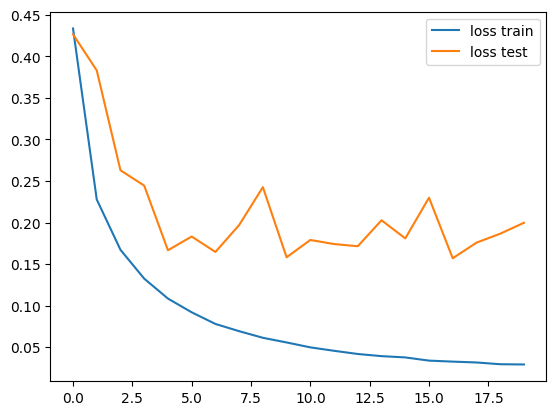

In [7]:
model = cnn_type_1(64,32)
train_a_model(model,train_loader,test_set,epochs = 20,lr=1e-3)

trop de classes 0 sont prédits en 1 2, 3 ,4. une piste d'amélioration pour ce modèle est d'aller voir ces signaux. sinon le reste ca va
ce qui en soit se traduit par envoyer des non malades faire de plus amples examens donc cela n'est pas si grave.

### modèle type 2 example: couches de 64 puis 64 puis 64 neurones

Epoch : 1/20 -- Training loss 0.41245348046204217, --- Val loss 0.4542366862297058, --- accuray : 0.5945769265251099, --- recall : 0.8859119186697001
Epoch : 2/20 -- Training loss 0.19825974898771026, --- Val loss 0.23324933648109436, --- accuray : 0.6847397046284482, --- recall : 0.9032172909401164
Epoch : 3/20 -- Training loss 0.1395929731127018, --- Val loss 0.24574397504329681, --- accuray : 0.6678298465569035, --- recall : 0.9087865217941677
Epoch : 4/20 -- Training loss 0.10852514636984023, --- Val loss 0.1898222416639328, --- accuray : 0.7131011606923788, --- recall : 0.9186485068139246
Epoch : 5/20 -- Training loss 0.08895040178613271, --- Val loss 0.21545755863189697, --- accuray : 0.6910047554421543, --- recall : 0.9240089586006137
Epoch : 6/20 -- Training loss 0.0740408715548849, --- Val loss 0.20130912959575653, --- accuray : 0.7156570029520515, --- recall : 0.9166871397352641
Epoch : 7/20 -- Training loss 0.06230012762383334, --- Val loss 0.14241644740104675, --- accuray :

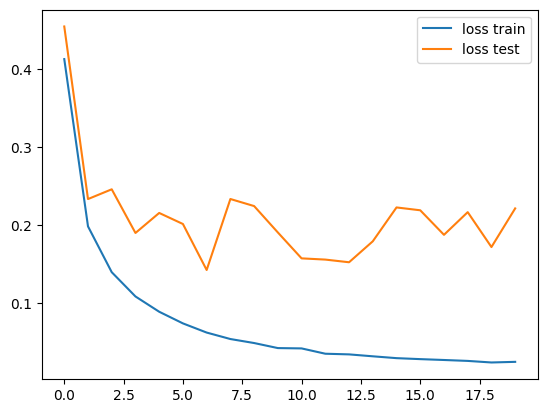

In [8]:
model = cnn_type_2(64,32,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = 20,lr=1e-3)

la même chose 

In [ ]:
model = cnn_type_2(128,32,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = 20,lr=1e-3)

Epoch : 1/20 -- Training loss 0.45150488151266027, --- Val loss 0.42165759205818176, --- accuray : 0.6105052190626756, --- recall : 0.8865005254796632
Epoch : 2/20 -- Training loss 0.2113189863199368, --- Val loss 0.3562158942222595, --- accuray : 0.6111981506213914, --- recall : 0.9012385370146507
Epoch : 3/20 -- Training loss 0.14825112780839061, --- Val loss 0.17529168725013733, --- accuray : 0.7302250749782733, --- recall : 0.913714951413587
Epoch : 4/20 -- Training loss 0.11178686806218376, --- Val loss 0.25023913383483887, --- accuray : 0.6666657040991536, --- recall : 0.9186955284975318
Epoch : 5/20 -- Training loss 0.08856653420940543, --- Val loss 0.147862046957016, --- accuray : 0.7741650733274564, --- recall : 0.9116849175688305
Epoch : 6/20 -- Training loss 0.07373211932715584, --- Val loss 0.18368497490882874, --- accuray : 0.7328248003729189, --- recall : 0.9077471228108701
Epoch : 7/20 -- Training loss 0.0650920537167896, --- Val loss 0.17526206374168396, --- accuray : 0

### conclusion

les modèles ont du mal a classer les anormaux.il faudrait soit ajouter du dropout soit augmenter le dataset.

## base de données  sans smote 6000 signaux

In [9]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_perturb_6000.csv')
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')
print(X_train.shape)
X_train =np.expand_dims(X_train,axis=1)
X_test =np.expand_dims(X_test,axis=1)

print(X_train.shape)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))

train_loader = DataLoader(train_set, batch_size=20, shuffle=True)

(32500, 187)
(32500, 1, 187)


Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            512
├─ReLU: 1-2                              --
├─MaxPool1d: 1-3                         --
├─Conv1d: 1-4                            20,544
├─ReLU: 1-5                              --
├─MaxPool1d: 1-6                         --
├─Conv1d: 1-7                            12,352
├─ReLU: 1-8                              --
├─MaxPool1d: 1-9                         --
├─Conv1d: 1-10                           12,352
├─ReLU: 1-11                             --
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           18,464
├─ReLU: 1-15                             --
├─Linear: 1-16                           165
Total params: 64,389
Trainable params: 64,389
Non-trainable params: 0
Epoch : 1/20 -- Training loss 0.5609197380015484, --- Val loss 0.629306972026825, --- accuray : 0.49725438500139346, --- recall : 0.8380397445924992
Epoch : 2/

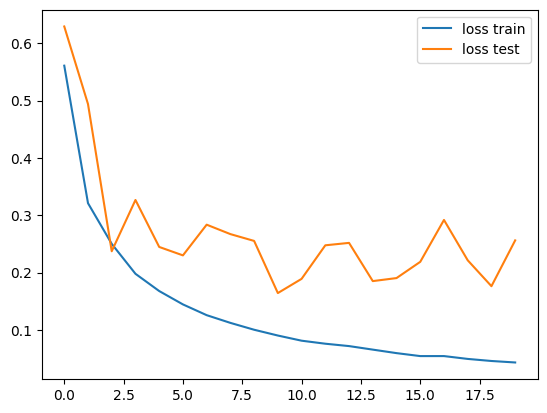

In [10]:
model = cnn_type_1(64,32)
train_a_model(model,train_loader,test_set,epochs = 20,lr=1e-3)

## plus grande base de données

In [11]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')
print(X_train.shape)
X_train =np.expand_dims(X_train,axis=1)
X_test =np.expand_dims(X_test,axis=1)

print(X_train.shape)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)

(250000, 187)
(250000, 1, 187)


Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            512
├─ReLU: 1-2                              --
├─MaxPool1d: 1-3                         --
├─Conv1d: 1-4                            20,544
├─ReLU: 1-5                              --
├─MaxPool1d: 1-6                         --
├─Conv1d: 1-7                            12,352
├─ReLU: 1-8                              --
├─MaxPool1d: 1-9                         --
├─Conv1d: 1-10                           12,352
├─ReLU: 1-11                             --
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           18,464
├─ReLU: 1-15                             --
├─Linear: 1-16                           165
Total params: 64,389
Trainable params: 64,389
Non-trainable params: 0
Epoch : 1/20 -- Training loss 0.26990668163485826, --- Val loss 0.16000738739967346, --- accuray : 0.7418557444755979, --- recall : 0.9093533519885758
Epoch : 

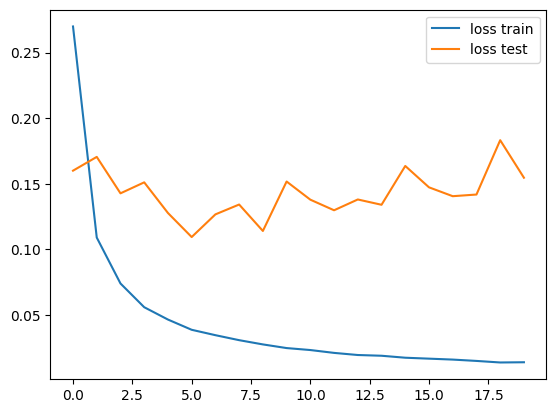

In [12]:
model = cnn_type_1(64,32)
train_a_model(model,train_loader,test_set,epochs = 20,lr=1e-3)

Bon modele

### base de données smote seul

In [14]:
Xo,yo = load_balanced.load_balanced_data(method='smote',n_normal=50000,
                       smote_perturb_smote_ratio=0.5)
pd.DataFrame(np.concatenate((Xo,np.expand_dims(yo,axis=1)),axis=1)).to_csv('../data/processed/mitbih_train_smote_50000.csv',index=None,header=None)

In [19]:
X_train =Xo
y_train = yo
X_train =np.expand_dims(Xo,axis=1)

X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')

X_test =np.expand_dims(X_test,axis=1)

print(X_train.shape)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)

(250000, 1, 187)


Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            512
├─ReLU: 1-2                              --
├─MaxPool1d: 1-3                         --
├─Conv1d: 1-4                            20,544
├─ReLU: 1-5                              --
├─MaxPool1d: 1-6                         --
├─Conv1d: 1-7                            12,352
├─ReLU: 1-8                              --
├─MaxPool1d: 1-9                         --
├─Conv1d: 1-10                           12,352
├─ReLU: 1-11                             --
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           18,464
├─ReLU: 1-15                             --
├─Linear: 1-16                           165
Total params: 64,389
Trainable params: 64,389
Non-trainable params: 0
Epoch : 1/20 -- Training loss 0.2819364800773561, --- Val loss 0.2959892451763153, --- accuray : 0.6471361471283019, --- recall : 0.9055826177770069
Epoch : 2/

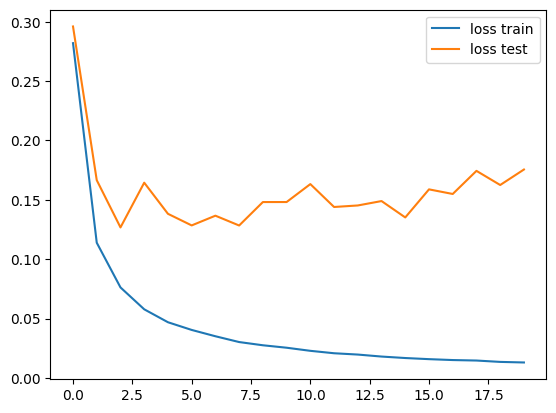

In [20]:
model = cnn_type_1(64,32)
train_a_model(model,train_loader,test_set,epochs = 20,lr=1e-3)